In [1]:
import sys
import os
from typing import Dict, List
import warnings

import numpy as np
import loompy
import glob
import matplotlib.pyplot as plt
from pygenometracks import tracks

import pyBigWig
from cytograph.visualization.colors import *

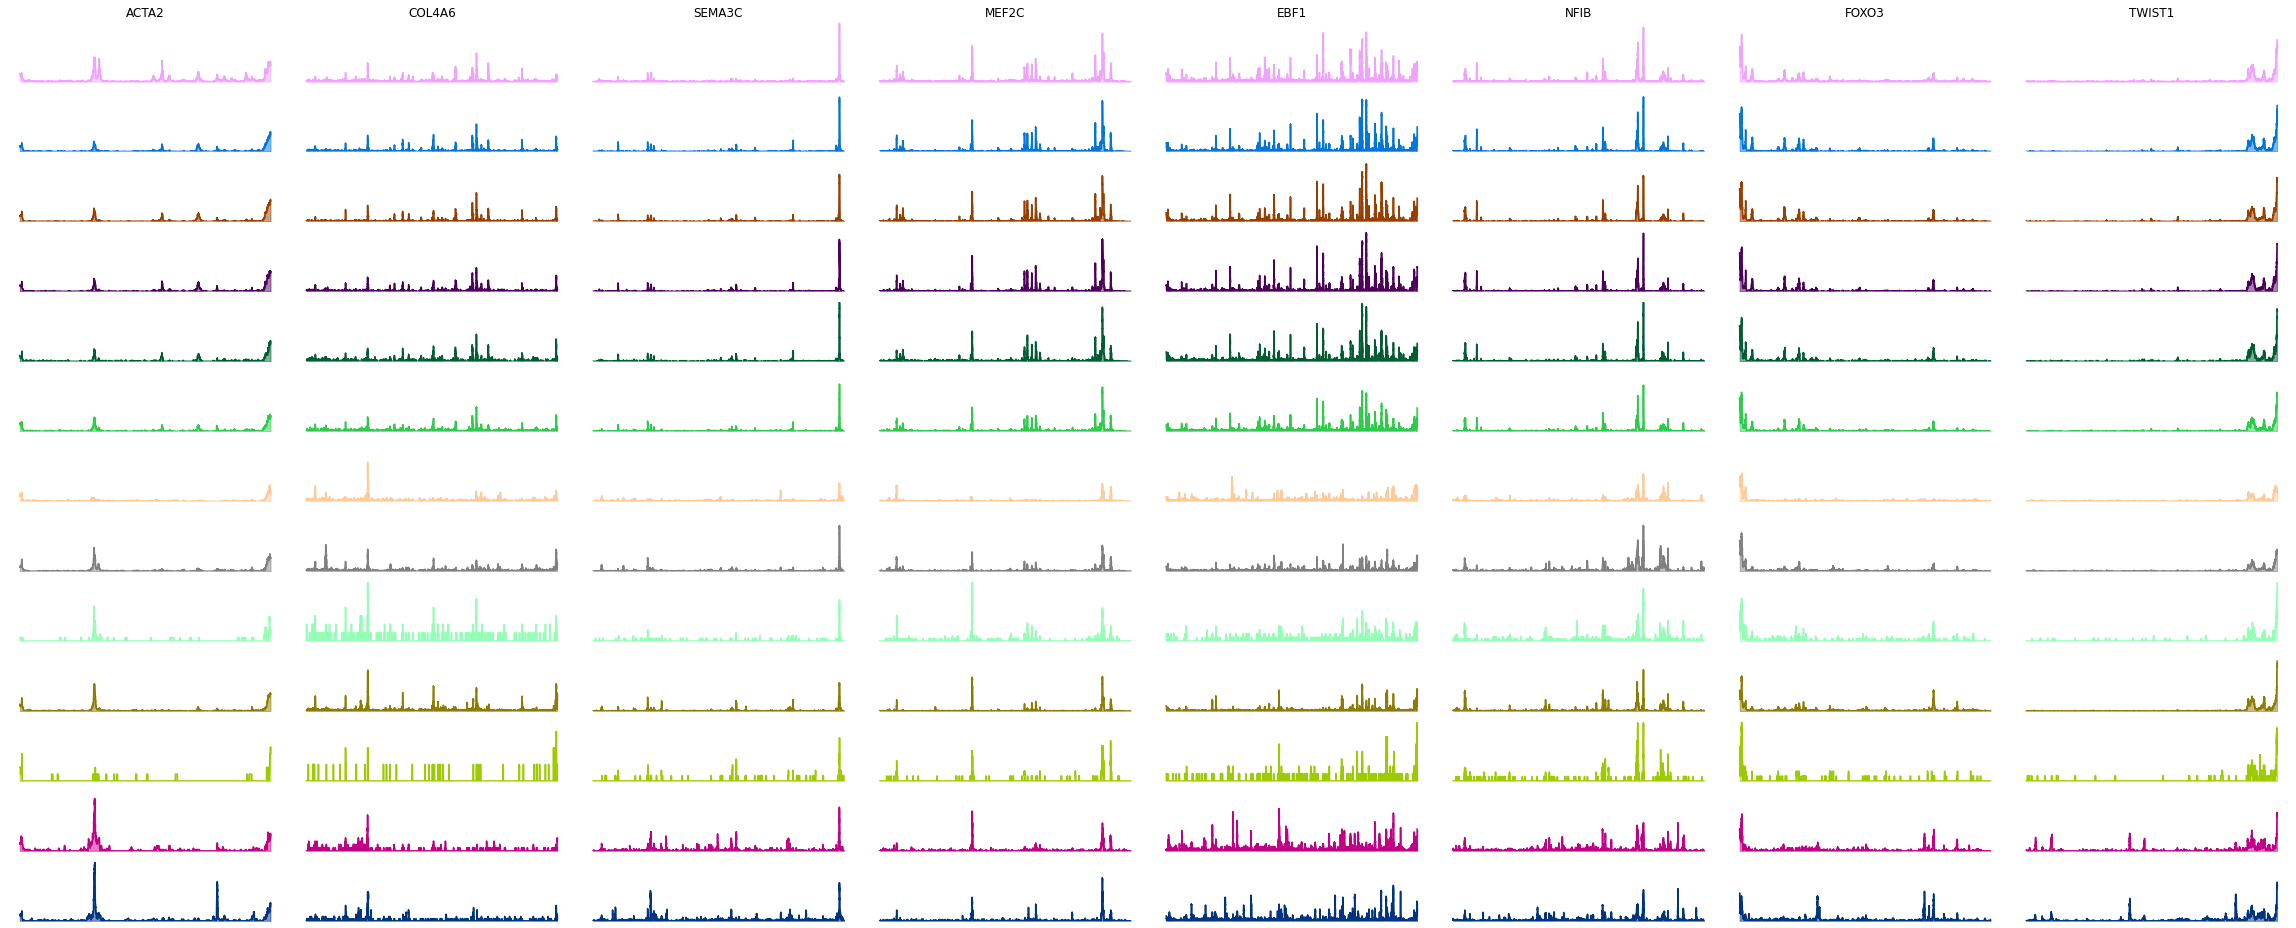

In [46]:
## Plot bigwigs

## This is for plotting genes
genes = ['ACTA2', 'COL4A6', 'SEMA3C', 'MEF2C', 'EBF1', 'NFIB', 'FOXO3', 'TWIST1']

s = 'All_FBL'
bigwig_dir = f'/proj/DEV_ATAC/Build_20220906_classes/{s}/bigwigs/'
f_RNA = f'/proj/DEV_ATAC/Build_20220906_classes/{s}/{s}_RNA.loom'

N_files = len(glob.glob(bigwig_dir + '/*.bw'))
files = [os.path.join(bigwig_dir, f'cluster_{i}.bw') for i in range(N_files)]

with loompy.connect(f_RNA) as ds:
    ranges = []
    for g in genes:
        x = np.where(ds.ra.Gene==g)[0]
        ranges.append([g, 'chr'+ds.ra.Chromosome[x][0], ds.ra.Start[x][0], ds.ra.End[x][0]])

x = np.fromiter(range(N_files),'int')
colors = Colorizer(scheme='colors75').fit(x).transform(x)

# fig, ax = plt.subplots(N_files, len(ranges), figsize=((2*len(ranges)), int(np.ceil(0.5*N_files))))
fig, ax = plt.subplots(N_files, len(ranges), figsize=((4*len(ranges)), N_files))

for c, ran in enumerate(ranges):
    data = []
    for i in range(N_files):
        with pyBigWig.open(files[i]) as bw:
            data.append(np.nan_to_num(bw.values(ran[1], ran[2], ran[3], numpy=True),0))

    x = np.fromiter(range(len(data[0])), dtype=int)
    height = max([max(x) for x in data])
    for i, v in enumerate(data):
        ax[i,c].plot(v, color=colors[i])
        ax[i,c].fill_between(x,v, alpha=.5, color = colors[i])
        ax[i,c].set_ylim(0,height)
        ax[i,c].axis('off')
    ax[0,c].set_title(ran[0])
plt.tight_layout()

In [3]:
build = '/data/proj/scATAC/chromograph/build_20200623/Cerebellum'
peak_dir = os.path.join(build, 'peaks')
out_dir = os.path.join(build, 'exported')
f = os.path.join(build, 'Cerebellum_GA.loom')

100%|██████████| 100985/100985 [00:06<00:00, 16475.07it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 7.9799999999999995,-0.08


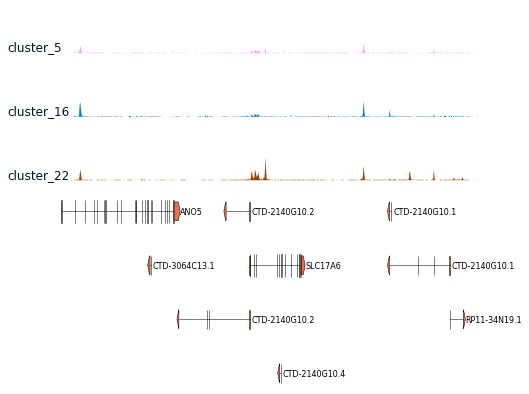

In [9]:
from cytograph.plotting.colors import colors75
from matplotlib.colors import to_hex
def plot_bigWig(ds: loompy.LoomConnection, gene, peak_dir, out_file, clusters: List[str] = None, padding = 10000):
    '''
    '''
    if clusters is None:
        ## Plot track for all clusters
        files = glob.glob(os.path.join(peak_dir, '*.bw'))
        ids = [int(f.split('_')[-1].split('.')[0]) for f in files]
        idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(ids))]
        files = [files[i] for i in idx]  
        
    else:
        ## Generate paths to requested clusters
        files = [os.path.join(peak_dir, f'cluster_{i}.bw') for i in clusters]

    bed_ref = '/home/camiel/gencode.basic.annotation.sort.bed12'
    height = len(files) * [1]
    height.append(4)
    fig, ax = plt.subplots(len(files)+1,1, figsize = (8,len(files)+4), gridspec_kw={'height_ratios': height})

    
    loc = ds.ra.loc[ds.ra.Gene == gene][0]
    chrom = loc.split(':')[0]
    start, end = [int(x) for x in loc.split(':')[1].split('-')]
    
    ## Add padding
    start = start - padding
    end = end + padding

    ## Plot each track
    for i, file in enumerate(files):
        title = file.split('/')[-1].split('.')[0]
        properties_dict = {'file': file, 'title': title, 'color':to_hex(colors75[i]), 'max_value': 10, 'alpha': 1}
        bw = tracks.BigWigTrack(properties_dict)

        bw.plot(ax[i], chrom, start, end)
        ax[i].text(-0.1, 0.01, title, verticalalignment='bottom', horizontalalignment='left', 
                   transform=ax[i].transAxes, color='#021426', fontsize=12)

        ## Aesthetics
        ax[i].axis("off")
        
    ## Plot gene reference
    properties_dict = {'file': bed_ref, 'title': 'Gencode', 'color': '#abd9e9', 'color_utr': '#f46d43', 'height_utr': .8, 'fontsize': 8, 
                       'merge_transcripts': 'true', 'prefered_name': 'gene_name', 'style': 'flybase', 'labels': 'true',
                       'dpi': 144}
    gene = tracks.BedTrack(properties_dict)
    ax[-1].set_xlim(start, end)
    ax[-1].axis("off")
    gene.plot(ax[-1], chrom, start, end)

    plt.savefig(out_file)

with loompy.connect(f, 'r') as ds:
    gene = 'SLC17A6'
    subset = f.split('/')[-2]
    plot_bigWig(ds, gene, peak_dir, clusters = [5, 16, 22], out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf', padding=150000)
#     plot_bigWig(ds, gene, peak_dir, clusters = [16, 12, 13, 1, 2, 10], out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf', padding=50000)

#     plot_bigWig(ds, gene, peak_dir, clusters = [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf')
#     plot_bigWig(ds, gene, peak_dir, out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf')

100%|██████████| 100985/100985 [00:06<00:00, 15779.12it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 7.9799999999999995,-0.08


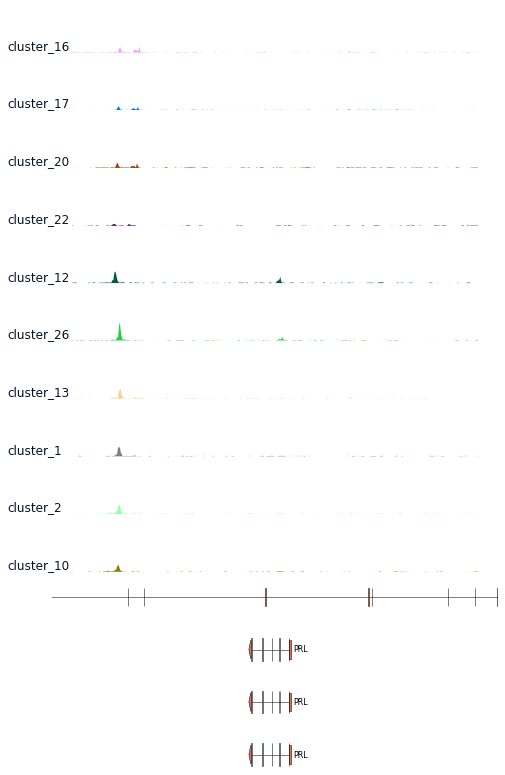

In [65]:
with loompy.connect(f, 'r') as ds:
    gene = 'PRL'
    subset = f.split('/')[-2]
    plot_bigWig(ds, gene, peak_dir, clusters = [16, 17, 20, 22, 12, 26, 13, 1, 2, 10], out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf', padding=50000)

100%|██████████| 100985/100985 [00:06<00:00, 14849.05it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 7.9799999999999995,-0.08


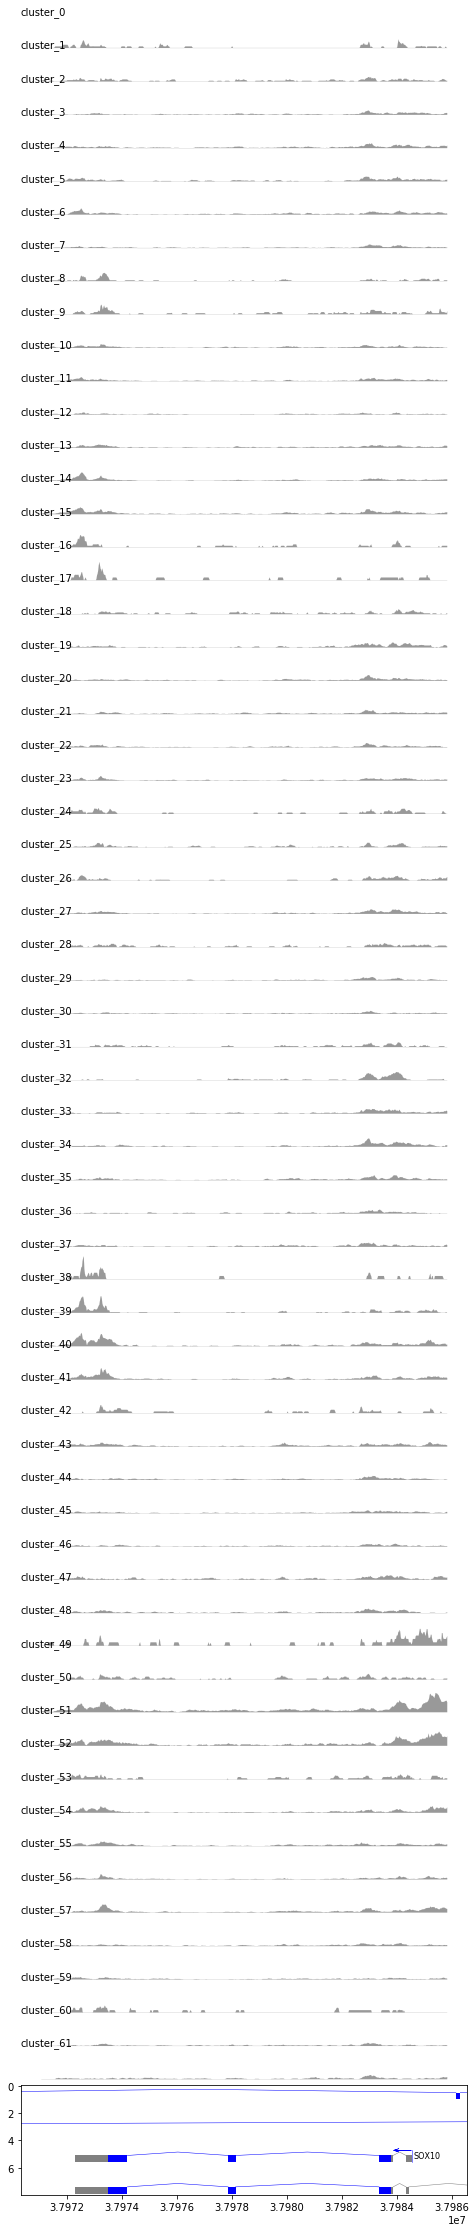

In [146]:
files = glob.glob(os.path.join(peak_dir, '*.bw'))
ids = [int(f.split('_')[-1].split('.')[0]) for f in files]
idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(ids))]
files = [files[i] for i in idx]

bed_ref = '/home/camiel/gencode.basic.annotation.sort.bed12'
height = len(files) * [1]
height.append(4)
fig, ax = plt.subplots(len(files)+1,1, figsize = (8,40), gridspec_kw={'height_ratios': height})

chrom = 'chr22'
start = 37970312
end = 37986555

## Plot each track
for i, file in enumerate(files):
    title = file.split('/')[-1].split('.')[0]
    properties_dict = {'file': file, 'height': 3, 'title': file.split('/')[-1].split('.')[0], 'color':'gray', 'max_value': 5, 'alpha': 0.8}
    bw = tracks.BigWigTrack(properties_dict)

#     ax[i].set_xlim(122747201, 122786077) 
    bw.plot(ax[i], chrom, start, end)
    ax[i].set_title(title, loc='left', fontsize=10)

    ## Aesthetics
    ax[i].axis("off")
    
## Plot gene reference
properties_dict = {'file': bed_ref, 'height': 10, 'title': 'Gencode', 'color': 'blue', 'fontsize': 8, 
                   'merge_transcripts': 'true', 'prefered_name': 'gene_name', 'style': 'tssarrow', 'labels': 'true'}
gene = tracks.BedTrack(properties_dict)
ax[-1].set_xlim(start, end)
gene.plot(ax[-1], chrom, start, end)

plt.savefig('test.pdf')

In [ ]:
# make a properties dict using as keys the values from the 
# documentation
properties_dict = {'file': <path to file>, 'height': 3, 'title'='bigwig', 'color'='red}

# initialize a bigwig track with the properties_dict. Any of the available tracks can be
# initialized in the same way
bw = BigWigTrack(properties_dict)

# to plot the region two axes are needed, one for the plot itself and the other for the legend.
figure, (track_ax, label_ax) = plt.subplots(1, 2)

# the plot method of all track classes expects 5 values, the track_ax, 
# the label_ax, and the genomic region to plot (chrom, start, end).
bw.plot(track_ax, label_ax, chrom, start, end)

In [ ]:
## Correlate promoters to peaks

def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [1]:
## By Coordinate

In [46]:
from cytograph.plotting.colors import colors75
from matplotlib.colors import to_hex
def plot_bigWig_coords(ds: loompy.LoomConnection, loc, peak_dir, out_file, clusters: List[str] = None, padding = 10000):
    '''
    '''
    if clusters is None:
        ## Plot track for all clusters
        files = glob.glob(os.path.join(peak_dir, '*.bw'))
        ids = [int(f.split('_')[-1].split('.')[0]) for f in files]
        idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(ids))]
        files = [files[i] for i in idx]  
        
    else:
        ## Generate paths to requested clusters
        files = [os.path.join(peak_dir, f'cluster_{i}.bw') for i in clusters]

    enh_ref = '/data/proj/tumor/Kriegstein/outputs/enhancers_1.bed'
    height = len(files) * [1]
    height.append(4)
    fig, ax = plt.subplots(len(files)+1,1, figsize = (8,len(files)+4), gridspec_kw={'height_ratios': height})

    
    chrom = loc.split(':')[0]
    start, end = [int(x) for x in loc.split(':')[1].split('-')]
    
    ## Add padding
    start = start - padding
    end = end + padding

    ## Plot each track
    for i, file in enumerate(files):
        title = file.split('/')[-1].split('.')[0]
        properties_dict = {'file': file, 'title': title, 'color':to_hex(colors75[i]), 'max_value': 10, 'alpha': 1}
        bw = tracks.BigWigTrack(properties_dict)

        bw.plot(ax[i], chrom, start, end)
        ax[i].text(-0.1, 0.01, title, verticalalignment='bottom', horizontalalignment='left', 
                   transform=ax[i].transAxes, color='#021426', fontsize=12)

        ## Aesthetics
        ax[i].axis("off")
        
    ## Plot gene reference
    properties_dict = {'file': enh_ref, 'title': 'Gencode', 'color': '#abd9e9', 'color_utr': '#f46d43', 'height_utr': .8, 'fontsize': 8, 
                       'merge_transcripts': 'true', 'prefered_name': 'gene_name', 'style': 'flybase', 'labels': 'true',
                       'dpi': 144}
    enh = tracks.BedTrack(properties_dict)
    ax[-1].set_xlim(start, end)
    ax[-1].axis("off")
    enh.plot(ax[-1], chrom, start, end)
    ax[-1].plot

    plt.savefig(out_file)

In [47]:
f = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.loom'
peakdir = '/proj/DEV_ATAC/Kriegstein_20200729/All/peaks/'
GLIOMA = np.array([ 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21])

with loompy.connect(f, 'r') as ds:
    rest = np.array([x for x in np.unique(ds.ca.Clusters) if x not in GLIOMA ])
    clusters = np.hstack([GLIOMA, rest])

100%|██████████| 200/200 [00:00<00:00, 34058.50it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1.08,-0.08


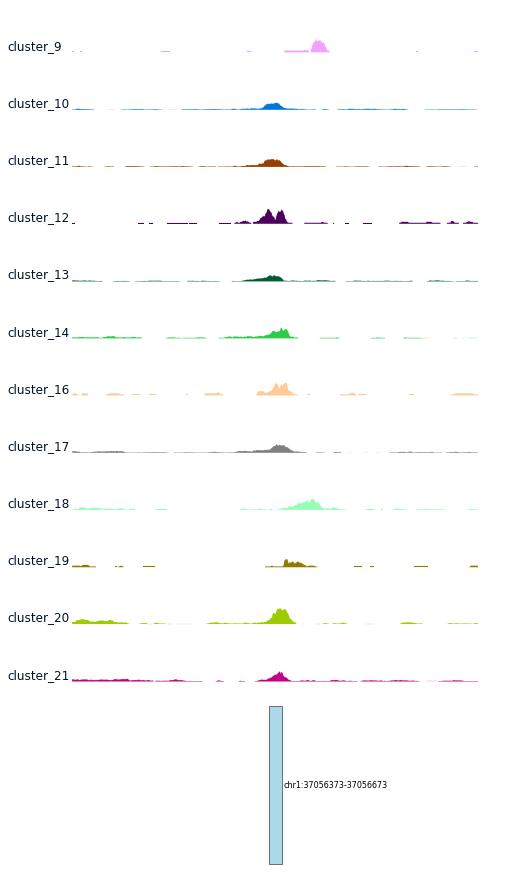

In [55]:
with loompy.connect(f, 'r') as ds:
    peak_ID = 'chr1:37056373-37056673'
    plot_bigWig_coords(ds, peak_ID, peakdir, clusters = GLIOMA, out_file= f'/home/camiel/misc/Glioma_enhancers_track.pdf', padding=5000)

In [10]:
from matplotlib.colors import to_hex
from pybedtools import BedTool
from typing import List
import numpy as np
import os
import matplotlib.pyplot as plt
import pyBigWig
from cytograph.plotting.colors import colors75

def plot_bigWig_coords_rows(pos_file, bigwig_dir, out_file, IDs: List[str] = None, padding = 300, colors:dict=None, N_rows = None, plot_colnames: bool = True):
    '''
    '''
    if IDs is None:
        ## Plot track for all clusters
        files = glob.glob(os.path.join(bigwig_dir, '*.bw'))
        IDs = [int(f.split('_')[-1].split('.')[0]) for f in files]
        idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(IDs))]
        files = [files[i] for i in idx]
    else:
        ## Generate paths to requested clusters
        files = [os.path.join(bigwig_dir, f'{i}.bw') for i in IDs]
        
    pos = np.array(BedTool(pos_file))
    if N_rows:
        pos = pos[:N_rows]
    chrom = pos[:,0]
    start = pos[:,1].astype(int) - padding
    end = pos[:,2].astype(int) + padding
        
    width = len(files)
    heigth = pos.shape[0]
    fig, ax = plt.subplots(pos.shape[0],len(files), figsize=(width, heigth))
      
    ## Plot each track
    for r in range(pos.shape[0]):
        data = []
        for c, file in enumerate(files):
            with pyBigWig.open(file) as bw:
                data.append(np.nan_to_num(bw.values(chrom[r], start[r], end[r], numpy=True),0))

        height = max([max(x) for x in data])
        x = np.fromiter(range(len(data[0])), dtype=int)
        x2 = x[padding:-padding]
        for i, v in enumerate(data):
            col = colors[IDs[i]]
            ax[r,i].plot(v, color = col, lw=.5)
            ax[r,i].fill_between(x,v, alpha=.5, color = col)
            ax[r,i].fill_between(x2,v[x2], alpha=.7, color = col)
            ax[r,i].set_ylim(0,height)
            ax[r,i].axis('off')
        plt.tight_layout()
        
        if plot_colnames:
            if r == 0:
                for c in range(len(data)):
                    ax[0,c].set_title(IDs[c])
            
    plt.savefig(out_file, dpi=300, bbox_inches='tight')
    
from matplotlib.colors import to_hex
from pybedtools import BedTool
from typing import List
import numpy as np
import os
import matplotlib.pyplot as plt
import pyBigWig
from cytograph.plotting.colors import colors75

def plot_bigWig_coords_cols(pos_file, bigwig_dir, out_file, IDs: List[str] = None, padding = 300, colors:dict=None, N_cols = None, plot_rownames: bool = True):
    '''
    '''
    if IDs is None:
        ## Plot track for all clusters
        files = glob.glob(os.path.join(bigwig_dir, '*.bw'))
        IDs = [int(f.split('_')[-1].split('.')[0]) for f in files]
        idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(IDs))]
        files = [files[i] for i in idx]
    else:
        ## Generate paths to requested clusters
        files = [os.path.join(bigwig_dir, f'{i}.bw') for i in IDs]
        
    pos = np.array(BedTool(pos_file))
    if N_cols:
        pos = pos[:N_cols]
    chrom = pos[:,0]
    start = pos[:,1].astype(int) - padding
    end = pos[:,2].astype(int) + padding
        
    width = pos.shape[0]
    heigth = len(files)
    fig, ax = plt.subplots(len(files),pos.shape[0], figsize=(width, heigth))
      
    ## Plot each track
    for c in range(pos.shape[0]):
        data = []
        for r, file in enumerate(files):
            with pyBigWig.open(file) as bw:
                data.append(np.nan_to_num(bw.values(chrom[c], start[c], end[c], numpy=True),0))

        width = max([max(x) for x in data])
        x = np.fromiter(range(len(data[0])), dtype=int)
        x2 = x[padding:-padding]
        for i, v in enumerate(data):
            row = colors[IDs[i]]
            ax[i,c].plot(v, color = row, lw=.5)
            ax[i,c].fill_between(x,v, alpha=.5, color = row)
            ax[i,c].fill_between(x2,v[x2], alpha=.7, color = row)
            ax[i,c].set_ylim(0,width)
            ax[i,c].axis('off')
        plt.tight_layout()
        
        if plot_rownames:
            if c == 0:
                for r in range(len(data)):
                    ax[r,0].set_title(IDs[c])
            
    plt.savefig(out_file, dpi=300, bbox_inches='tight')

ValueError: Image size of 2100x90000 pixels is too large. It must be less than 2^16 in each direction.

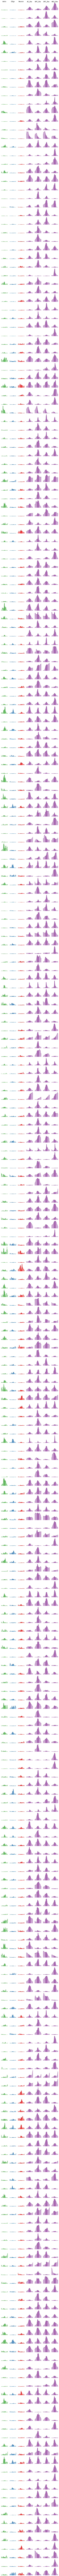

In [12]:
f = '/datb/sl/camiel/tumor/outputs/enhancers_20221013/trimmed/GBM/GBM.bed'

colors = {
    'AC_like': '#984ea3',
    'NPC_like': '#984ea3',
    'OPC_like': '#984ea3',
    'MES_like': '#984ea3',
    'Neuron': '#e41a1c',
    'Oligo': '#377eb8',
    'Astro': '#4daf4a',
}
plot_bigWig_coords_rows(f, '/datb/sl/camiel/tumor/visualize_enhancers/20221013/', '/home/camiel/misc/enhancers_20221013.png', 
                        ['Astro', 'Oligo', 'Neuron', 'AC_like', 'NPC_like', 'OPC_like', 'MES_like'], padding = 300, colors=colors)

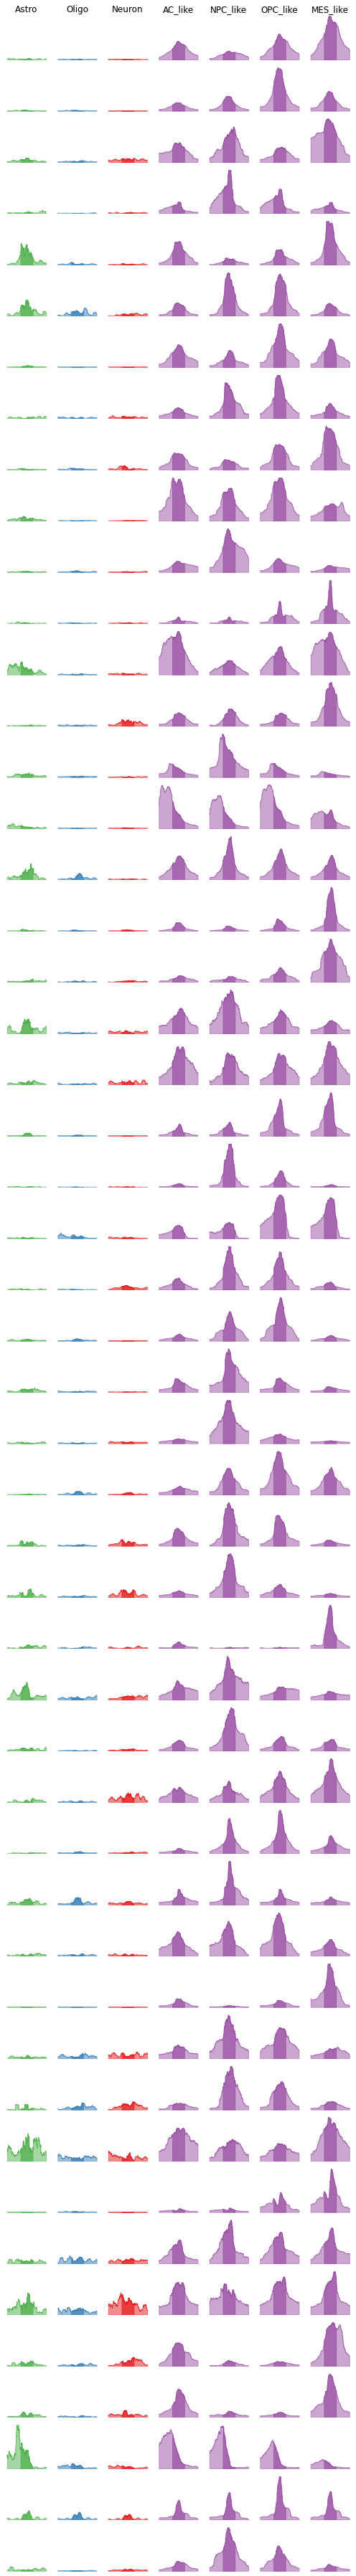

In [14]:
f = '/datb/sl/camiel/tumor/outputs/enhancers_20221013/trimmed/GBM/GBM.bed'

colors = {
    'AC_like': '#984ea3',
    'NPC_like': '#984ea3',
    'OPC_like': '#984ea3',
    'MES_like': '#984ea3',
    'Neuron': '#e41a1c',
    'Oligo': '#377eb8',
    'Astro': '#4daf4a',
}
plot_bigWig_coords_rows(f, '/datb/sl/camiel/tumor/visualize_enhancers/20221013/', '/home/camiel/misc/enhancers_20221013_n50.png', 
                        ['Astro', 'Oligo', 'Neuron', 'AC_like', 'NPC_like', 'OPC_like', 'MES_like'], padding = 300, colors=colors, N_rows=50)

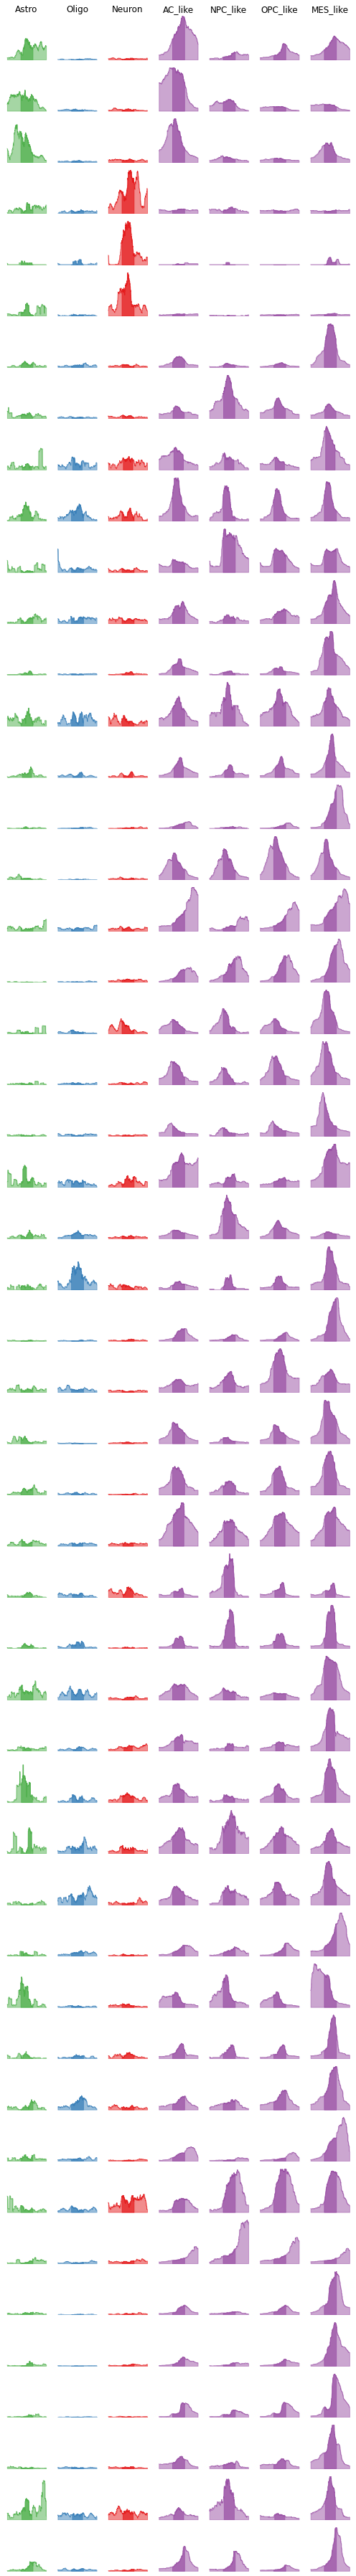

In [12]:
f = '/datb/sl/camiel/tumor/outputs/enhancers_20221013/trimmed/previous/enhancer_fragments_AAV_20210415.bed'

colors = {
    'AC_like': '#984ea3',
    'NPC_like': '#984ea3',
    'OPC_like': '#984ea3',
    'MES_like': '#984ea3',
    'Neuron': '#e41a1c',
    'Oligo': '#377eb8',
    'Astro': '#4daf4a',
}
plot_bigWig_coords_rows(f, '/datb/sl/camiel/tumor/visualize_enhancers/20221013/', '/home/camiel/misc/enhancers_20221013_previous.png', 
                        ['Astro', 'Oligo', 'Neuron', 'AC_like', 'NPC_like', 'OPC_like', 'MES_like'], padding = 300, colors=colors)

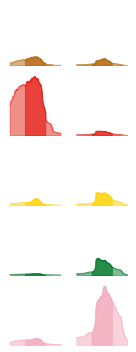

In [15]:
# colors = {
#     'CB_Exc': "#B36305", 
#     'HB_Exc': "#E32017", 
#     'TEL_Exc': "#FFD300", 
#     'Purk_Neur': "#00782A",
#     'MB_Inh': "#F3A9BB",
# }

colors = {
    'Purk_Neur': "#B36305",
    'CB_Exc': "#FFD300", 
    'HB_Exc': "#00782A", 
    'MB_Inh': "#E32017",
    'TEL_Exc': "#F3A9BB", 
}

f = '/proj/DEV_ATAC/ML_dev/20230118_submission/example_enh.bed'
bigwig_dir = '/proj/DEV_ATAC/Build_20220906_classes/All/bigwigs/'
out_file = '/home/camiel/misc/examples_ML_DEV.png'

# plot_bigWig_coords_rows(f, bigwig_dir, out_file, 
#                         ['Purk_Neur', 'MB_Inh', 'CB_Exc', 'HB_Exc', 'TEL_Exc'], padding = 300, colors=colors)

plot_bigWig_coords_cols(f, bigwig_dir, out_file, 
                        ['Purk_Neur', 'MB_Inh', 'CB_Exc', 'HB_Exc', 'TEL_Exc'], padding = 300, colors=colors, plot_rownames=False)

In [21]:
data = []

f = '/proj/DEV_ATAC/Build_20220906_classes/All/bigwigs/CB_Exc.bw'
# f = '/datb/sl/camiel/tumor/visualize_enhancers/20221013/AC_like.bw'

with pyBigWig.open(f) as bw:
    data.append(np.nan_to_num(bw.values('chr22', 46487102, 46487503, numpy=True),0))